## インスタンス化した後のコード

In [1]:
# ライブラリのインポート
from sae_trainer import train_all_layer_saes

/Users/itsukikuwahara/codes/research/sae/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### SAEの学習

In [2]:
# 学習に利用するテキスト
texts = [
    "A: Why are you carrying that wet umbrella? B: Because it started to rain on my way here, I had to use it.",
    "A: You seem very tired today. B: I am. I stayed up late to finish my report, so I didn't get much sleep.",
    "A: The room is so bright all of a sudden. What happened? B: I just pushed the main switch, which caused all the lights to turn on.",
    "A: I heard you passed the difficult exam. Congratulations! B: Thank you! I studied hard every day for it, so I'm glad my effort paid off."
    ]


Extracting activations from 12 layers of the model: bert-base-uncased
Extracting activations from layer 1/12...
Layer 1 activations shape: torch.Size([135, 768])
Extracting activations from layer 2/12...
Layer 2 activations shape: torch.Size([135, 768])
Extracting activations from layer 3/12...
Layer 3 activations shape: torch.Size([135, 768])
Extracting activations from layer 4/12...
Layer 4 activations shape: torch.Size([135, 768])
Extracting activations from layer 5/12...
Layer 5 activations shape: torch.Size([135, 768])
Extracting activations from layer 6/12...
Layer 6 activations shape: torch.Size([135, 768])
Extracting activations from layer 7/12...
Layer 7 activations shape: torch.Size([135, 768])
Extracting activations from layer 8/12...
Layer 8 activations shape: torch.Size([135, 768])
Extracting activations from layer 9/12...
Layer 9 activations shape: torch.Size([135, 768])
Extracting activations from layer 10/12...
Layer 10 activations shape: torch.Size([135, 768])
Extract

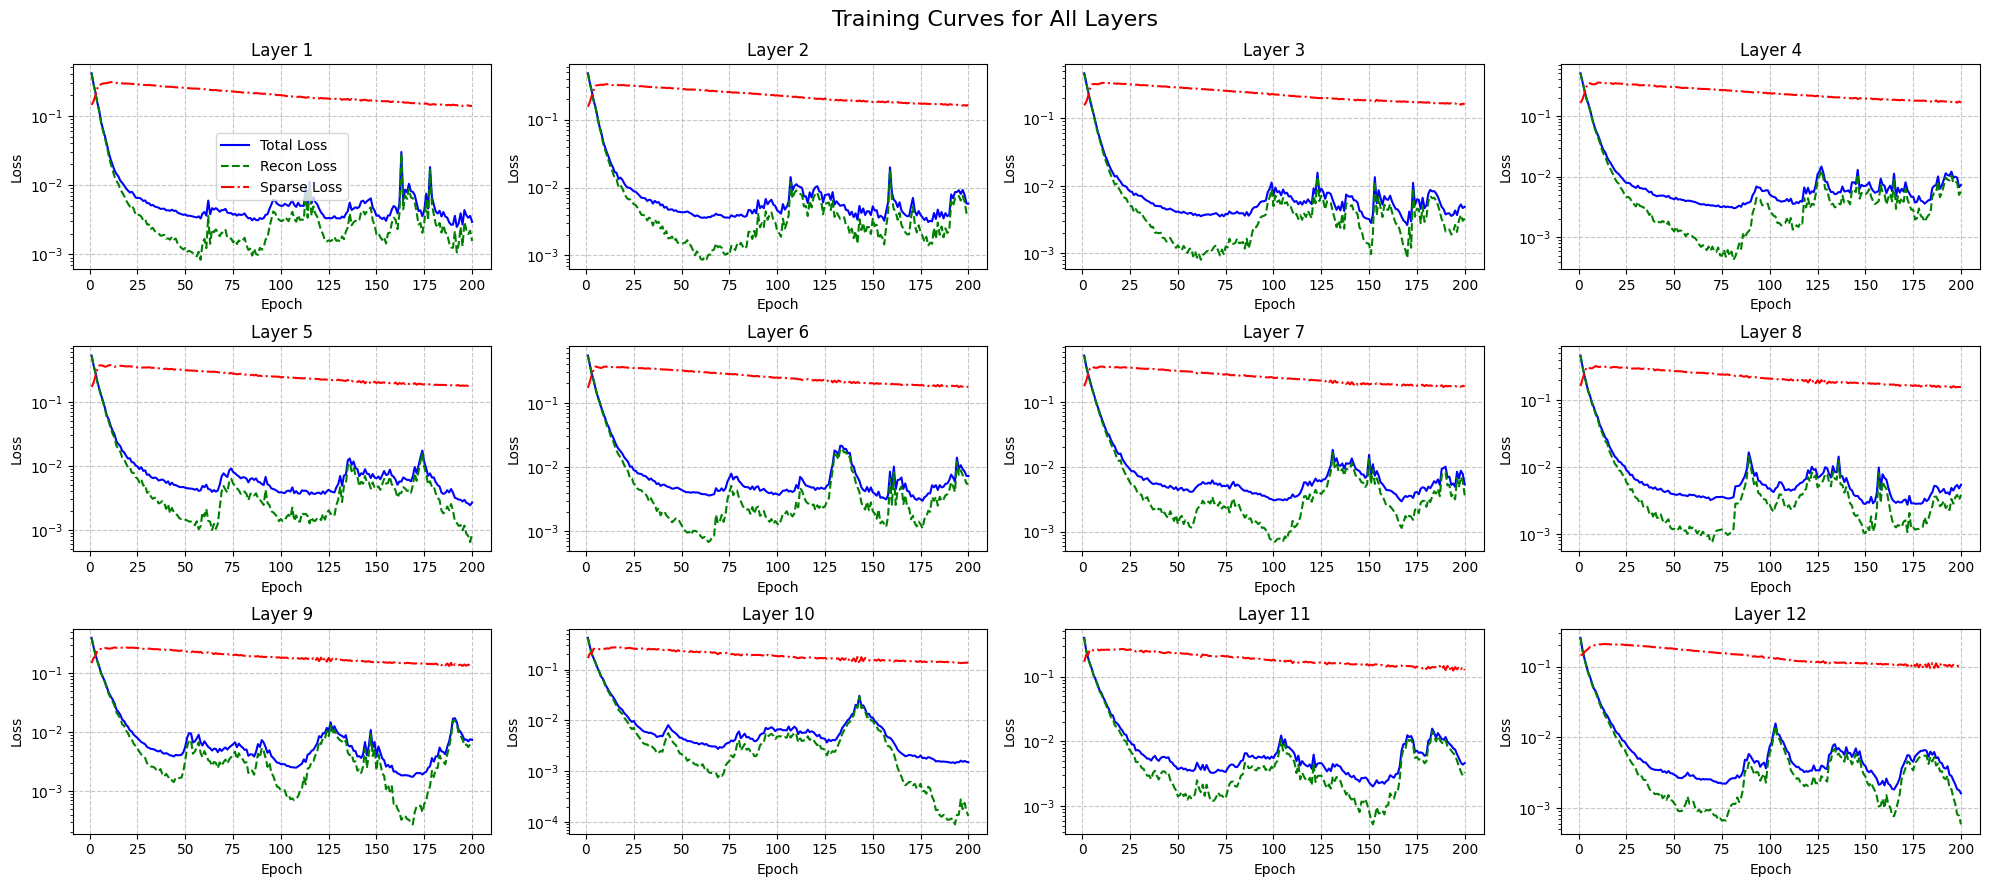

{0: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU()
   (decoder): Linear(in_features=844, out_features=768, bias=True)
 ),
 1: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU()
   (decoder): Linear(in_features=844, out_features=768, bias=True)
 ),
 2: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU()
   (decoder): Linear(in_features=844, out_features=768, bias=True)
 ),
 3: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU()
   (decoder): Linear(in_features=844, out_features=768, bias=True)
 ),
 4: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU()
   (decoder): Linear(in_features=844, out_features=768, bias=True)
 ),
 5: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU

In [3]:
#  設定
llm_model_name = "bert-base-uncased"
num_samples = len(texts)
batch_size = 32
sae_l1_coeff = 0.01

# 学習の実行
train_all_layer_saes(
    texts=texts,
    llm_model_name=llm_model_name,
    num_samples=num_samples,
    batch_size=batch_size,
    sae_l1_coeff=sae_l1_coeff
)

### 学習したSAEの可視化

In [7]:
# 可視化に必要なライブラリのインポート
from sae_visualization import SAEVisualizer

## インスタンス化する前のコード

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer

from activation_utils import get_llm_activations_residual_stream
from sae_trainer import create_data_loader, train_sparse_autoencoder, train_all_layer_saes

/Users/itsukikuwahara/codes/research/sae/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ## SAEの学習（特定の層） 

In [3]:
# extract_activationsの変数設定
llm_model_name = "bert-base-uncased"    # 使用するLLMモデル名    
texts = [
    # "The quick brown fox jumps over the lazy dog.",
    # "A large language model can process and generate text.",
    # "Cats enjoy sleeping in warm, sunny spots.",
    # "This is a sample text for testing the Sparse Autoencoder.",
    # "PyTorch is a widely used deep learning framework." ,
    "A: Why are you carrying that wet umbrella? B: Because it started to rain on my way here, I had to use it.",
    "A: You seem very tired today. B: I am. I stayed up late to finish my report, so I didn't get much sleep.",
    "A: The room is so bright all of a sudden. What happened? B: I just pushed the main switch, which caused all the lights to turn on.",
    "A: I heard you passed the difficult exam. Congratulations! B: Thank you! I studied hard every day for it, so I'm glad my effort paid off."
    ]  # 使用するテキスト
target_layer_idx = 4    # 抽出するLLMの層インデックス
num_samples_for_training = 4  # 訓練に使用するサンプル数

# create_data_loaderの変数設定
batch_size = 256  # バッチサイズ

# train_sparse_autoencoderの変数設定
num_epochs = 200  # 訓練エポック数
sae_l1_coeff = 1 # スパース性の度合いを調整する係数

In [3]:
tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
llm_model = AutoModel.from_pretrained(llm_model_name)
training_texts = [texts[i] for i in range(num_samples_for_training)]

activations, activations_dict = get_llm_activations_residual_stream(
    llm_model, tokenizer, training_texts, target_layer_idx
)

In [4]:
data_loader = create_data_loader(activations, batch_size)
sae_model, training_losses, resonctruction_losses, sparsity_losses, sae_feature_dim, input_dim = train_sparse_autoencoder(
    activations, data_loader, num_epochs, sae_l1_coeff, llm_model_name=llm_model_name
)

Using device: mps
----------LLM・SAEの情報----------
LLMモデル名: bert-base-uncased
対象層インデックス: 0
LLMの活性化ベクトルの次元数: 768, SAEの特徴次元: 844
----------------------------------

Starting SAE training for layer 0 for 200 epochs...
Epoch 1/200, Total Loss: 0.7664, Recon Loss: 0.5984, Sparse Loss: 0.1680
Epoch 2/200, Total Loss: 0.6571, Recon Loss: 0.5418, Sparse Loss: 0.1153
Epoch 3/200, Total Loss: 0.5989, Recon Loss: 0.5186, Sparse Loss: 0.0804
Epoch 4/200, Total Loss: 0.5643, Recon Loss: 0.5048, Sparse Loss: 0.0595
Epoch 5/200, Total Loss: 0.5407, Recon Loss: 0.4916, Sparse Loss: 0.0491
Epoch 6/200, Total Loss: 0.5215, Recon Loss: 0.4754, Sparse Loss: 0.0461
Epoch 7/200, Total Loss: 0.5040, Recon Loss: 0.4562, Sparse Loss: 0.0478
Epoch 8/200, Total Loss: 0.4877, Recon Loss: 0.4353, Sparse Loss: 0.0524
Epoch 9/200, Total Loss: 0.4724, Recon Loss: 0.4142, Sparse Loss: 0.0582
Epoch 10/200, Total Loss: 0.4574, Recon Loss: 0.3935, Sparse Loss: 0.0639
Epoch 11/200, Total Loss: 0.4424, Recon Loss: 0.3737, Sp

## SAEを学習（全ての層）

In [5]:
layer_saes = {}

layer_saes = train_all_layer_saes(
    llm_model_name, texts, num_samples_for_training, batch_size, num_epochs,sae_l1_coeff
    )


Extracting activations from 12 layers of the model: bert-base-uncased
Extracting activations from layer 1/12...
Extracting activations from layer 2/12...
Extracting activations from layer 3/12...
Extracting activations from layer 4/12...
Extracting activations from layer 5/12...
Extracting activations from layer 6/12...
Extracting activations from layer 7/12...
Extracting activations from layer 8/12...
Extracting activations from layer 9/12...
Extracting activations from layer 10/12...
Extracting activations from layer 11/12...
Extracting activations from layer 12/12...

Training SAE for layer 1...
Using device: mps
----------LLM・SAEの情報----------
LLMモデル名: bert-base-uncased
対象層インデックス: 1
LLMの活性化ベクトルの次元数: 768, SAEの特徴次元: 844
----------------------------------

Starting SAE training for layer 1 for 200 epochs...
Epoch 1/200, Total Loss: 0.5973, Recon Loss: 0.4485, Sparse Loss: 0.1488
Epoch 2/200, Total Loss: 0.5115, Recon Loss: 0.4075, Sparse Loss: 0.1040
Epoch 3/200, Total Loss: 0.4633, R

In [6]:
layer_saes

{0: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU()
   (decoder): Linear(in_features=844, out_features=768, bias=True)
 ),
 1: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU()
   (decoder): Linear(in_features=844, out_features=768, bias=True)
 ),
 2: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU()
   (decoder): Linear(in_features=844, out_features=768, bias=True)
 ),
 3: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU()
   (decoder): Linear(in_features=844, out_features=768, bias=True)
 ),
 4: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU()
   (decoder): Linear(in_features=844, out_features=768, bias=True)
 ),
 5: SparseAutoencoder(
   (encoder): Linear(in_features=768, out_features=844, bias=True)
   (relu): ReLU

## 各SAEを活性化させるトークンを可視化

In [5]:
activations_dict["A: Why are you carrying that wet umbrella? B: Because it started to rain on my way here, I had to use it."].shape

torch.Size([30, 768])

In [6]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")
sae_model.to(device)
# sae_model.eval()

Using device: mps


SparseAutoencoder(
  (encoder): Linear(in_features=768, out_features=844, bias=True)
  (relu): ReLU()
  (decoder): Linear(in_features=844, out_features=768, bias=True)
)

In [7]:
token_info_list = []
all_sae_features_list = []
global_token_idx = 0

# トークナイザーにpad_tokenが設定されているか確認 (活性化抽出時と条件を合わせるため)
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
        print(f"トークナイザーのpad_tokenをeos_token ({tokenizer.pad_token}) に設定しました。")
    else:
        # これはデモスクリプト (demo_train_sae_gpt.py, demo_sae_train.py) や
        # activation_utils.py 内の処理と整合性を取る必要があります。
        print("警告: トークナイザーにpad_tokenが設定されていません。'[PAD]'を追加します。")
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        # LLMモデルの埋め込み層のリサイズが必要な場合がある点に注意 (model.resize_token_embeddings(len(tokenizer)))

if not activations_dict:
    print("活性化辞書 (activations_dict) が空です。特徴分析をスキップします。")
else:
   for original_text, token_activations in activations_dict.items():
      # 活性ベクトルをGPUに転送
      token_activations = token_activations.to(device)
      
      # 学習済みのSAEモデルを使用して、トークンの活性化をエンコード
      with torch.no_grad():
         sae_model_pre_relu = sae_model.encoder(token_activations)
         sae_features_for_text = sae_model.relu(sae_model_pre_relu)

      all_sae_features_list.append(sae_features_for_text.cpu())

      # トークンを取得
      inputs = tokenizer(original_text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
      
      # パディングトークンを除外するためにAttention Maskを使用
      attention_mask = inputs["attention_mask"].squeeze(0)
      input_ids_squeeze = inputs["input_ids"].squeeze(0)

      # トークンIDを取得
      actual_tokens_ids_for_text = input_ids_squeeze[attention_mask == 1]
      actual_tokens_str_list = tokenizer.convert_ids_to_tokens(actual_tokens_ids_for_text)

      if len(actual_tokens_str_list) != sae_features_for_text.shape[0]:
         print(f"Warning: Mismatch in token count for text: {original_text}")
         continue
      
      for token_idx_in_text in range(sae_features_for_text.shape[0]):
         token_info_list.append({
            "original_text": original_text,
            "token_idx_in_text": token_idx_in_text,   # テキスト内の実施あのトークンに対するインデックス
            "token_str": actual_tokens_str_list[token_idx_in_text],  # トークンの文字列表現
            "global_token_idx": global_token_idx,  # データセット全体を通したトークンのインデックス
         })
         
         global_token_idx += 1
         
# 以下結果の表示
if not all_sae_features_list:
   print("No SAE features found for the token.")

else:
   concatenated_sae_features = torch.cat(all_sae_features_list, dim=0)  # Shape: (num_tokens, sae_feature_dim)
   sae_total_features = concatenated_sae_features.shape[0]
   
   num_sae_features_to_analyze = min(10, sae_total_features) # 最大10個のSAE特徴を分析
   num_top_tokens_per_feature = 5  # 各SAE特徴に対して上位5つのトークンを分析

   # 指定した数のSAE特徴を分析するためのループ
   for feature_idx_to_analyze in range(num_sae_features_to_analyze):
      # 現在のSAE特徴次元に対応する前トークンの活性を取得
      feature_column_activation = concatenated_sae_features[:, feature_idx_to_analyze]
      
      # 上位k個の活性化とそのグローバルインデックスを取得
      actual_k = min(num_top_tokens_per_feature, len(feature_column_activation))
      if actual_k == 0 : continue
      
      top_k_values, top_k_global_indices = torch.topk(feature_column_activation, k=actual_k)
      
      print(f"\n--- SAE Feature {feature_idx_to_analyze} を最も強く活性化するトークン")
      
      if top_k_values.numel() == 0:
         print("No top tokens found for this feature.")
         continue
      
      # 上位k個のトークンの情報を表示
      for rank, (activation_value, global_token_idx_item) in enumerate(zip(top_k_values, top_k_global_indices)):
         global_idx = global_token_idx_item.item()    # テンソルから値を取り出す
         if global_idx < len(token_info_list):        
            token_info = token_info_list[global_idx]  # 取得したトークン情報
            
            text_snippet = token_info["original_text"]   # 元のテキスト
            
            # 文脈表示のために、元のテキストを再度トークナイズ(表示用)
            inputs_ctx = tokenizer(text_snippet,
                                 return_tensors="pt",
                                 truncation=True,
                                 max_length=128,
                                 padding="max_length",
                                 return_attention_mask=True)
            ids_ctx = inputs_ctx["input_ids"].squeeze()[inputs_ctx["attention_mask"].squeeze() == 1]
            tokens_ctx = tokenizer.convert_ids_to_tokens(ids_ctx)
            
            # 上記 tokens_ctx リスト内でのインデックスに相当
            tok_idx_in_ctx = token_info["token_idx_in_text"]
            
            context_window_size = 3    # 表示する前後のトークン数
            start_idx = max(0, tok_idx_in_ctx - context_window_size)
            end_idx = min(len(tokens_ctx), tok_idx_in_ctx + context_window_size + 1)
            
            context_display_parts = []                  
            for i in range(start_idx, end_idx):
               if i == tok_idx_in_ctx:
                  context_display_parts.append(f"**{tokens_ctx[i]}**")
               else:
                  context_display_parts.append(tokens_ctx[i])
            context_str = " ".join(context_display_parts)

            print(f"  順位 {rank + 1}: 活性化値 = {activation_value.item():.4f}")
            print(f"    トークン: '{token_info['token_str']}' (テキスト内の実トークンindex: {tok_idx_in_ctx})")
            print(f"    文脈: {context_str}")
            text_preview = (text_snippet[:70] + '...') if len(text_snippet) > 70 else text_snippet # テキストのプレビュー
            print(f"    元テキスト (一部): \"{text_preview}\"")
         else:
            print(f"  順位 {rank + 1}: エラー - グローバルインデックス {global_idx} が範囲外です。")                  
            


--- SAE Feature 0 を最も強く活性化するトークン
  順位 1: 活性化値 = 2.6317
    トークン: 'it' (テキスト内の実トークンindex: 24)
    文脈: every day for **it** , so i
    元テキスト (一部): "A: I heard you passed the difficult exam. Congratulations! B: Thank yo..."
  順位 2: 活性化値 = 2.3742
    トークン: 'it' (テキスト内の実トークンindex: 27)
    文脈: had to use **it** . [SEP]
    元テキスト (一部): "A: Why are you carrying that wet umbrella? B: Because it started to ra..."
  順位 3: 活性化値 = 1.6495
    トークン: 'it' (テキスト内の実トークンindex: 14)
    文脈: b : because **it** started to rain
    元テキスト (一部): "A: Why are you carrying that wet umbrella? B: Because it started to ra..."
  順位 4: 活性化値 = 0.4528
    トークン: '.' (テキスト内の実トークンindex: 10)
    文脈: the difficult exam **.** congratulations ! b
    元テキスト (一部): "A: I heard you passed the difficult exam. Congratulations! B: Thank yo..."
  順位 5: 活性化値 = 0.0000
    トークン: 'are' (テキスト内の実トークンindex: 4)
    文脈: a : why **are** you carrying that
    元テキスト (一部): "A: Why are you carrying that wet umbrella? B: Because it started to ra..."

In [8]:
import seaborn as sns
import pandas as pd
import japanize_matplotlib
from matplotlib.colors import LogNorm

##  トークンごとのSAE特徴を可視化

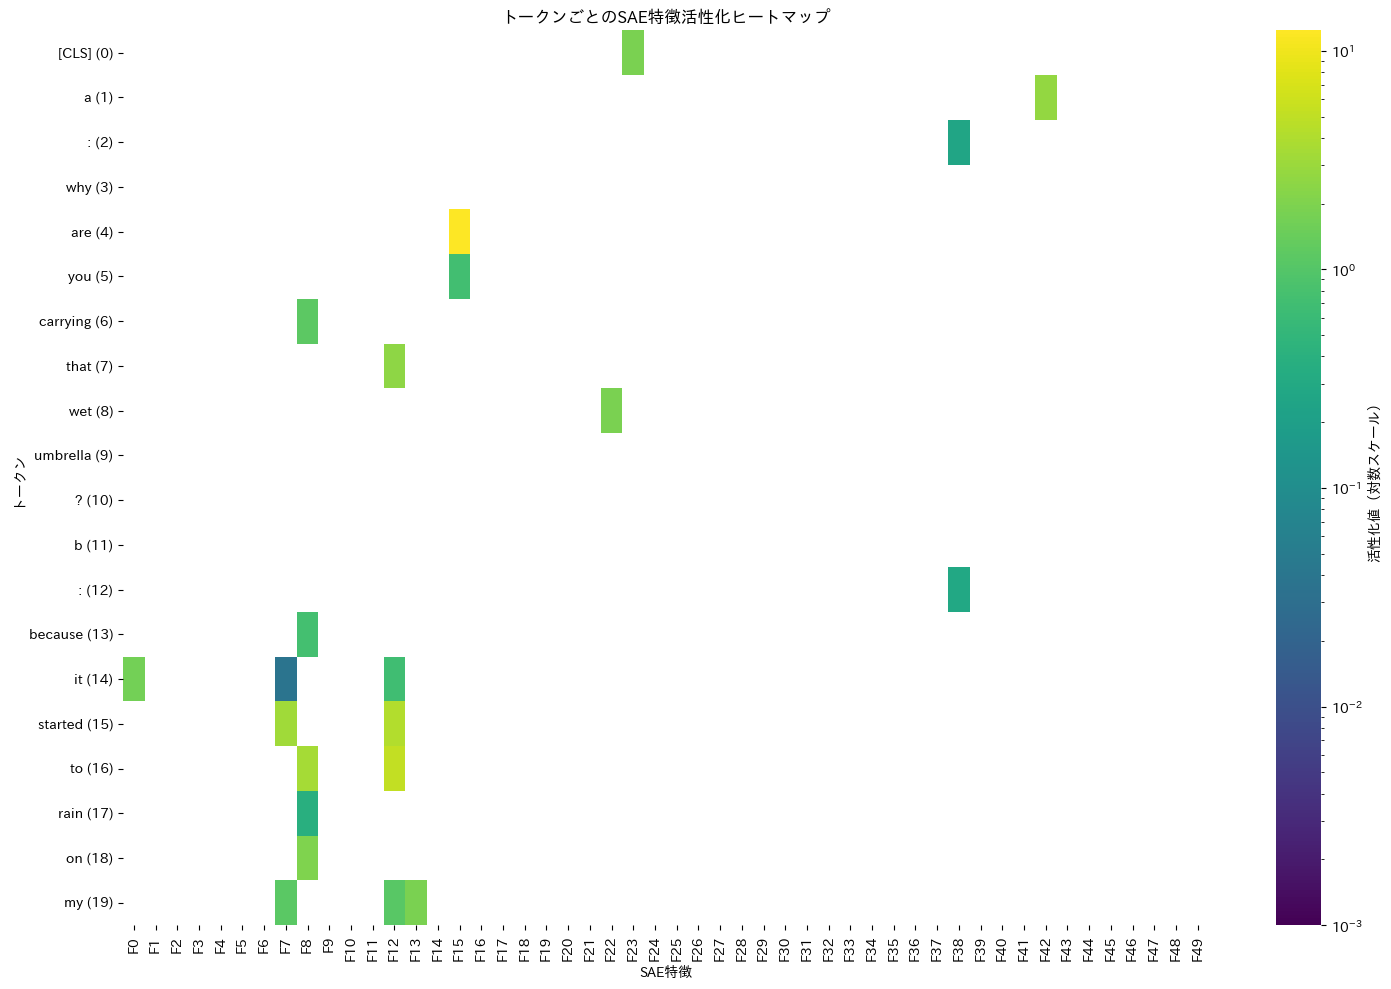

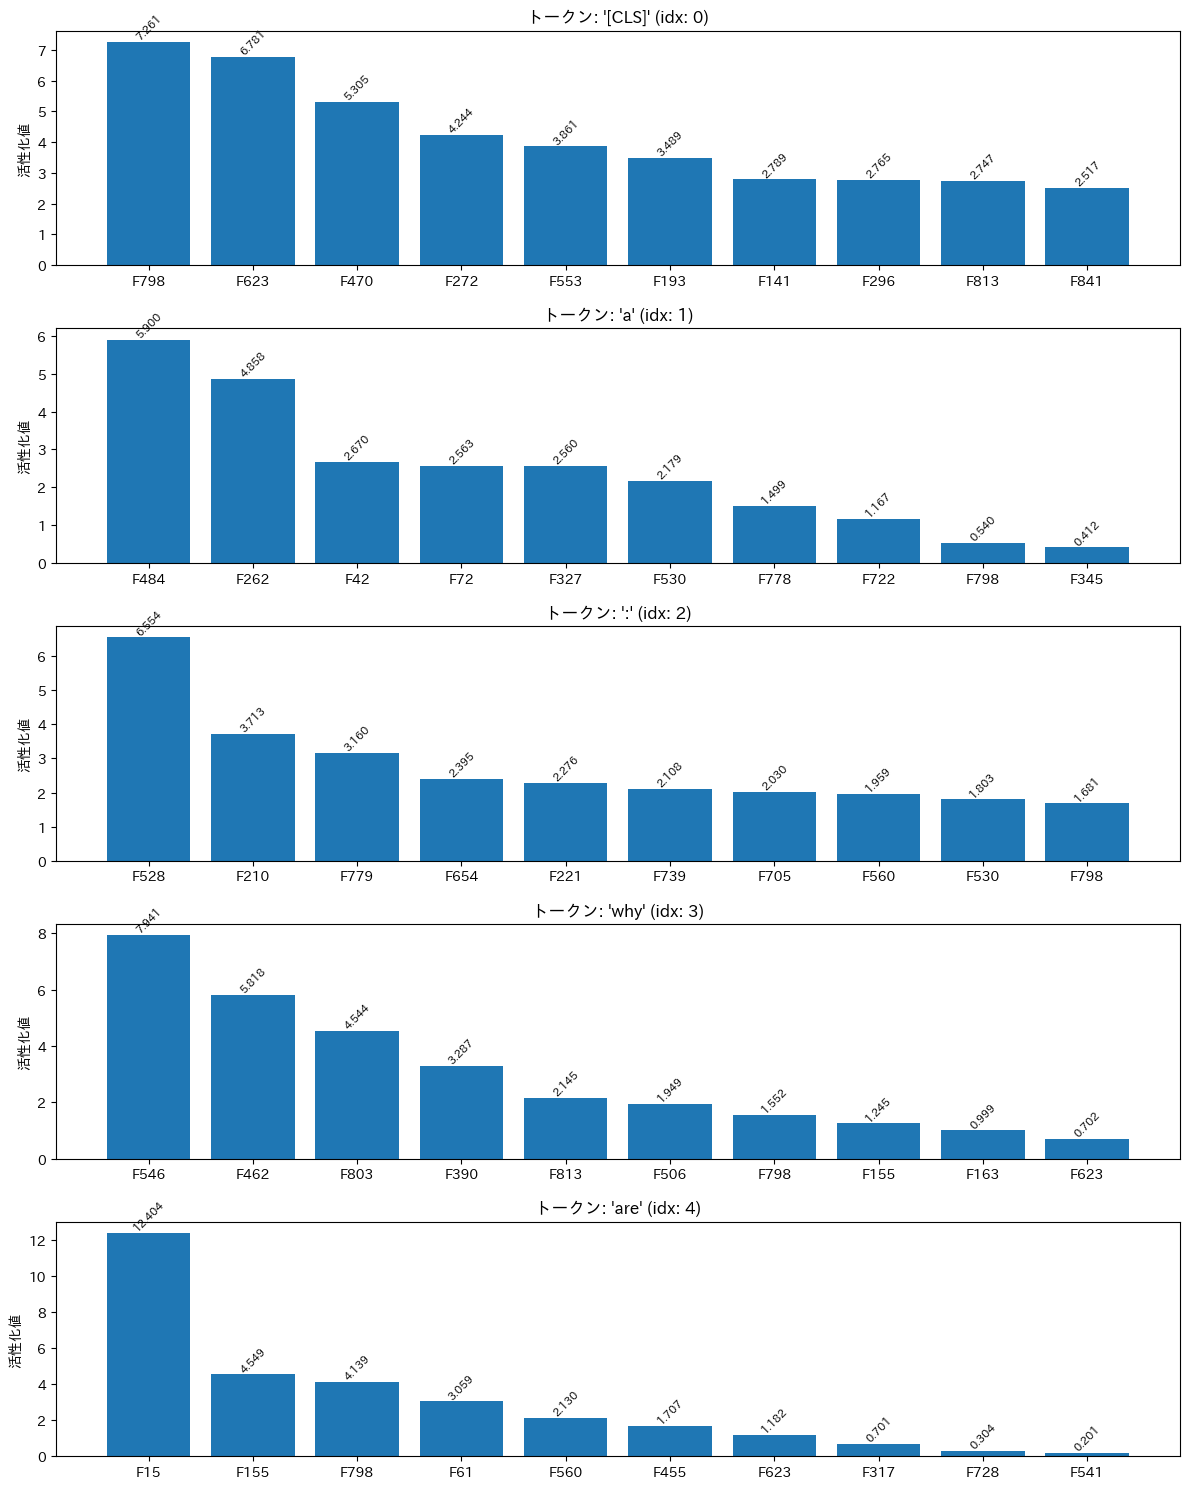

/var/folders/0b/2jjsbrb53vzdswyd_lflml000000gn/T/ipykernel_88486/585480768.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(token_strs, rotation=45, ha='right')
/var/folders/0b/2jjsbrb53vzdswyd_lflml000000gn/T/ipykernel_88486/585480768.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(token_strs, rotation=45, ha='right')
/var/folders/0b/2jjsbrb53vzdswyd_lflml000000gn/T/ipykernel_88486/585480768.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(token_strs, rotation=45, ha='right')
/var/folders/0b/2jjsbrb53vzdswyd_lflml000000gn/T/ipykernel_88486/585480768.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_

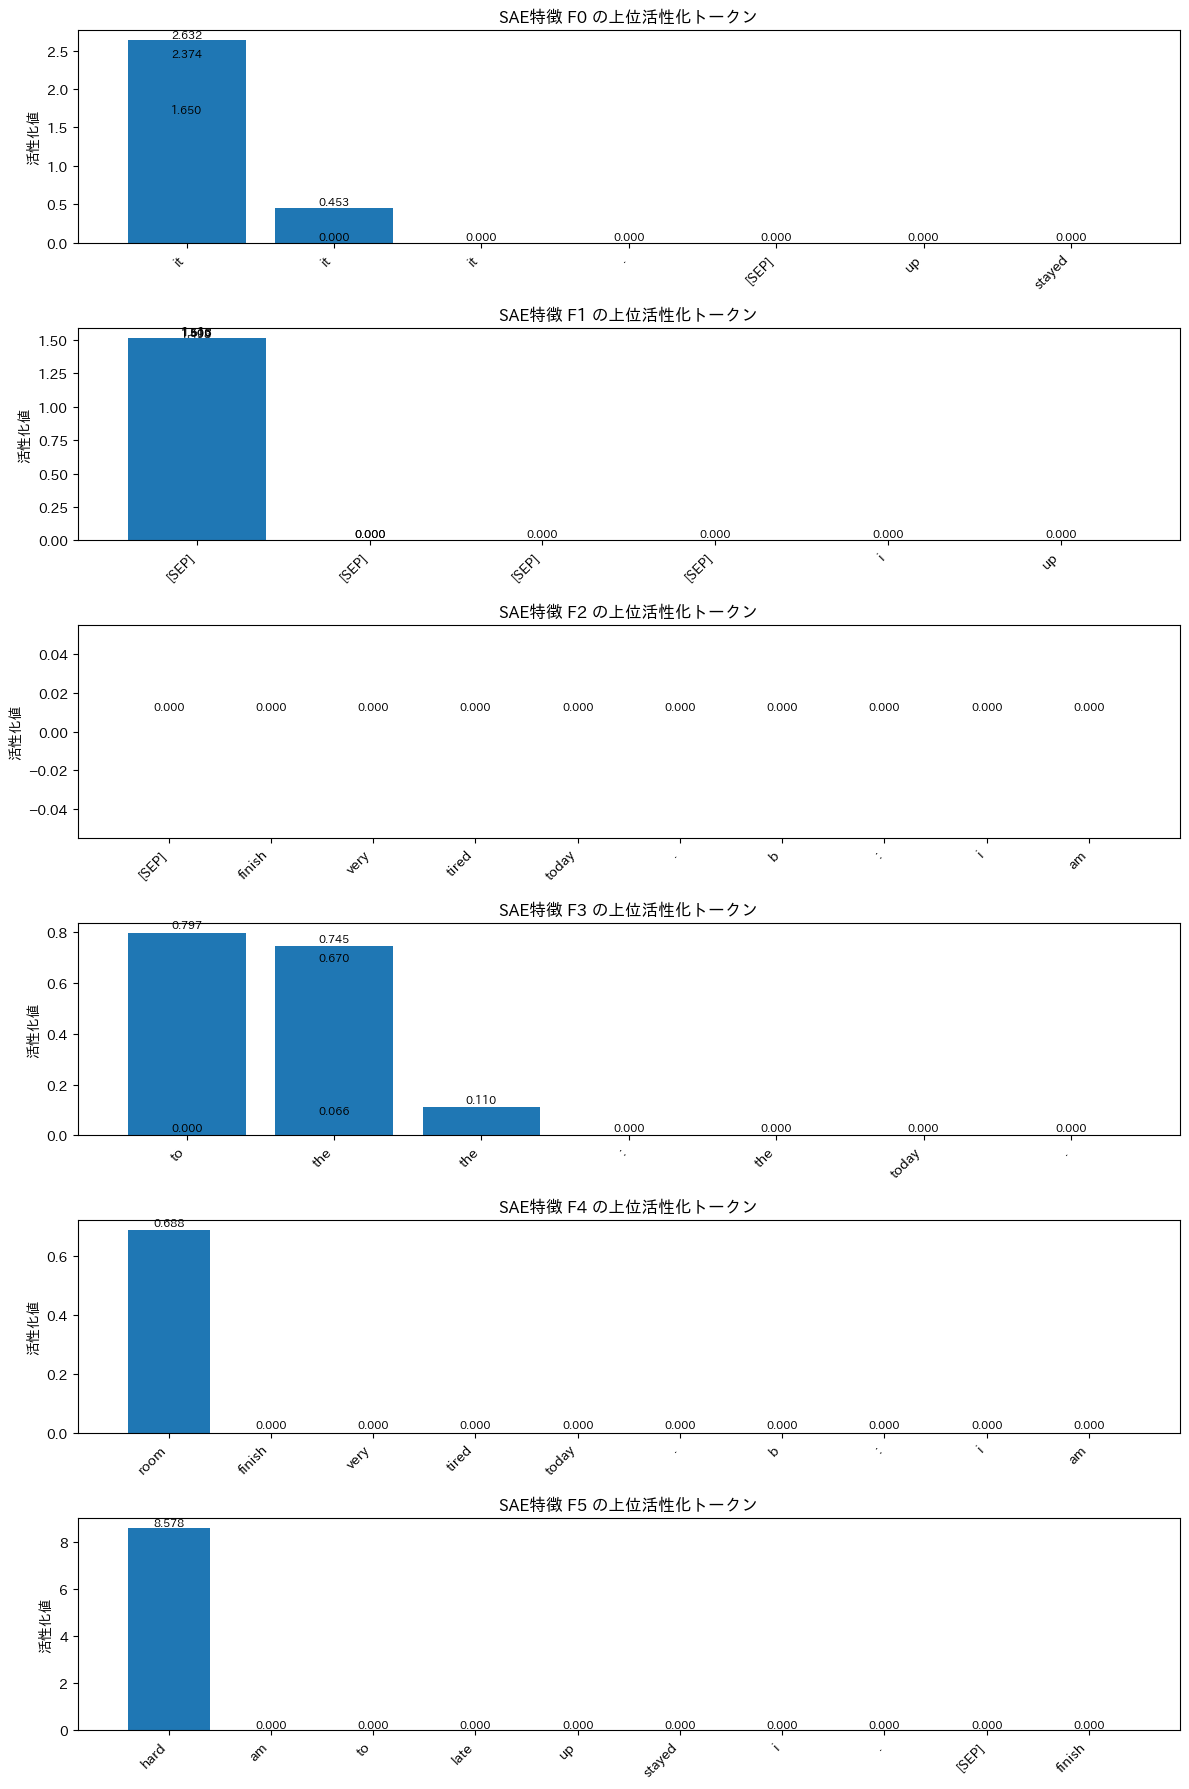

In [9]:
# トークンごとのSAE特徴活性化を可視化する

def visualize_token_feature_activations():
    # すでに計算済みのデータを使用
    if not all_sae_features_list or not token_info_list:
        print("活性化データまたはトークン情報が存在しません。")
        return
        
    # 全トークンの特徴活性化値を取得
    concatenated_features = torch.cat(all_sae_features_list, dim=0).cpu().numpy()
    
    # 表示するトークン数と特徴数を制限（大きすぎるとグラフが見づらくなるため）
    max_tokens_to_display = min(20, concatenated_features.shape[0])
    max_features_to_display = min(50, concatenated_features.shape[1])
    
    # 表示するデータの準備
    selected_tokens = token_info_list[:max_tokens_to_display]
    token_labels = [f"{info['token_str']} ({info['token_idx_in_text']})" for info in selected_tokens]
    
    # 特徴活性化データのサブセットを取得
    activations_subset = concatenated_features[:max_tokens_to_display, :max_features_to_display]
    
    # 1. ヒートマップによる可視化
    plt.figure(figsize=(15, 10))
    
    # ヒートマップの作成（対数スケールを使用して低い活性化値も見やすくする）
    sns.heatmap(
        activations_subset,
        xticklabels=[f"F{i}" for i in range(max_features_to_display)],
        yticklabels=token_labels,
        cmap="viridis",
        norm=LogNorm(vmin=max(0.001, activations_subset.min())), # 0より大きい最小値を設定
        cbar_kws={"label": "活性化値（対数スケール）"}
    )
    
    plt.title("トークンごとのSAE特徴活性化ヒートマップ")
    plt.xlabel("SAE特徴")
    plt.ylabel("トークン")
    plt.tight_layout()
    plt.show()
    
    # 2. 各トークンの上位活性化特徴を棒グラフで表示
    num_tokens_for_bar = min(5, max_tokens_to_display)  # 棒グラフで表示するトークン数を制限
    top_features_per_token = 10  # 各トークンについて表示する上位特徴数
    
    fig, axes = plt.subplots(num_tokens_for_bar, 1, figsize=(12, 3*num_tokens_for_bar))
    if num_tokens_for_bar == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        if i >= len(selected_tokens):
            break
            
        # このトークンの活性化値
        token_activations = concatenated_features[i]
        # 上位特徴を取得
        top_indices = np.argsort(token_activations)[::-1][:top_features_per_token]
        top_values = token_activations[top_indices]
        
        # 棒グラフの作成
        bars = ax.bar(
            [f"F{idx}" for idx in top_indices],
            top_values
        )
        
        # トークンの情報を表示
        token_info = selected_tokens[i]
        ax.set_title(f"トークン: '{token_info['token_str']}' (idx: {token_info['token_idx_in_text']})")
        ax.set_ylabel("活性化値")
        
        # 各バーの上に値を表示
        for bar, val in zip(bars, top_values):
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f"{val:.3f}",
                ha='center',
                va='bottom',
                fontsize=8,
                rotation=45
            )
    
    plt.tight_layout()
    plt.show()
    
    # 3. 特徴ごとの活性化分布を表示
    num_features_to_analyze = min(6, max_features_to_display)
    feature_indices = list(range(num_features_to_analyze))
    
    fig, axes = plt.subplots(len(feature_indices), 1, figsize=(12, 3*len(feature_indices)))
    if len(feature_indices) == 1:
        axes = [axes]
        
    for i, feature_idx in enumerate(feature_indices):
        feature_activations = concatenated_features[:, feature_idx]
        
        # 活性化値でソートして上位のトークンを取得
        sorted_indices = np.argsort(feature_activations)[::-1]
        top_n = min(10, len(sorted_indices))  # 上位10個のトークンを表示
        
        token_strs = [token_info_list[idx]['token_str'] for idx in sorted_indices[:top_n]]
        sorted_activations = feature_activations[sorted_indices[:top_n]]
        
        # 棒グラフの作成
        bars = axes[i].bar(token_strs, sorted_activations)
        axes[i].set_title(f"SAE特徴 F{feature_idx} の上位活性化トークン")
        axes[i].set_ylabel("活性化値")
        axes[i].set_xticklabels(token_strs, rotation=45, ha='right')
        
        # 各バーの上に値を表示
        for bar, val in zip(bars, sorted_activations):
            axes[i].text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f"{val:.3f}",
                ha='center',
                va='bottom',
                fontsize=8
            )
    
    plt.tight_layout()
    plt.show()

# 可視化関数を実行
visualize_token_feature_activations()